<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/new_1/modelling_logTransformed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [2]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [3]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+'train_Log Transformed.pkl' #log transformed
test_file = file_path+'test_Log Transformed.pkl'
dataset= "Log Transformed"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 359), (11403, 359), (75818, 359))

In [4]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) #getting true positive rate, false positive rate
    auc = metrics.roc_auc_score(y_true,y_pred) #getting auc score
    log_loss = metrics.log_loss(y_true,y_pred) #getting logloss
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1) #auc=0.5 line 
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])

  else:
    plt.figure(figsize=(12,8))
    for k,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[k]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

In [5]:
def find_best_params(model,params,cv=10,n_jobs=-1,X_train=X_train):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [6]:
def plot_feature_importance(df,feat_imp,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat) #plotting feature importance 
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [7]:
def get_top_features(df,feat_imp,top=50):
  """
  gets the top features.
  if top is of integer dtype it will return top features,
  if top is between 0 and 1, it will return features that have at least feature importance value= top
  """
  if (top>0.)&(top<=1.): #getting the features that have feature importance value greater than top
    feature_to_consider = [1 if i>=top else 0 for i in feat_imp]
    most_important_feat = [i  for i,j in zip(df.columns,feature_to_consider) if (j==1)]#getiing the columns names
  else:
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
  return most_important_feat    

# Modeling

# Logistic Regression

In [8]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [9]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished


The best auc score was 0.798
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}
CPU times: user 9.71 s, sys: 1.4 s, total: 11.1 s
Wall time: 4min 59s


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=10, penalty='l2',
                  solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Log Transformed dataset 		 



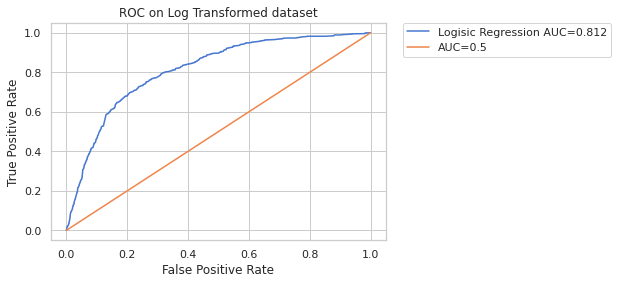

The log loss and auc was found to be 0.542 and 0.812 for Logisic Regression on Log Transformed dataset.


In [ ]:
labels=[] #storing all labels
y_preds = [] #storing all y_pred
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.542156,0.812097


# Decision Trees

In [10]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [11]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished


The best auc score was 0.787
The best params were: {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': 100, 'max_depth': 10}
CPU times: user 4.76 s, sys: 364 ms, total: 5.12 s
Wall time: 5min 47s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                        splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features=None,
                                                             max_leaf_nodes=5000,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=7,
                                                             min_samples_split=500,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
         

		 Decision Tree Classifier on Log Transformed dataset 		 



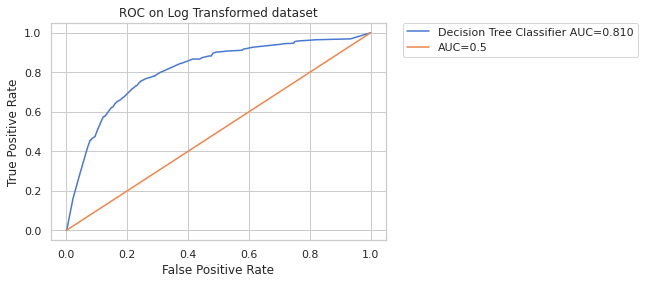

The log loss and auc was found to be 0.141 and 0.810 for Decision Tree Classifier on Log Transformed dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.542156,0.812097
1,Decision Tree Classifier,Log Transformed,0.140804,0.810465


# Random Forest

In [12]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [13]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 72.8min finished


The best auc score was 0.817
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 3min 7s, sys: 616 ms, total: 3min 8s
Wall time: 1h 15min 57s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

%time model.fit(X_train,y_train)

CPU times: user 10min 3s, sys: 2.51 s, total: 10min 6s
Wall time: 5min 8s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [17]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier on Log Transformed dataset 		 



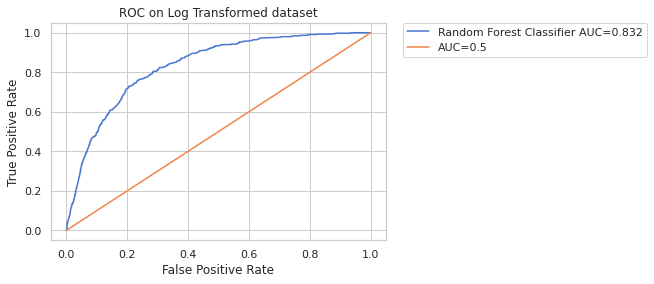

The log loss and auc was found to be 0.138 and 0.832 for Random Forest Classifier on Log Transformed dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.542156,0.812097
1,Decision Tree Classifier,Log Transformed,0.140804,0.810465
2,Random Forest Classifier,Log Transformed,0.137558,0.832106


# Selecting top features

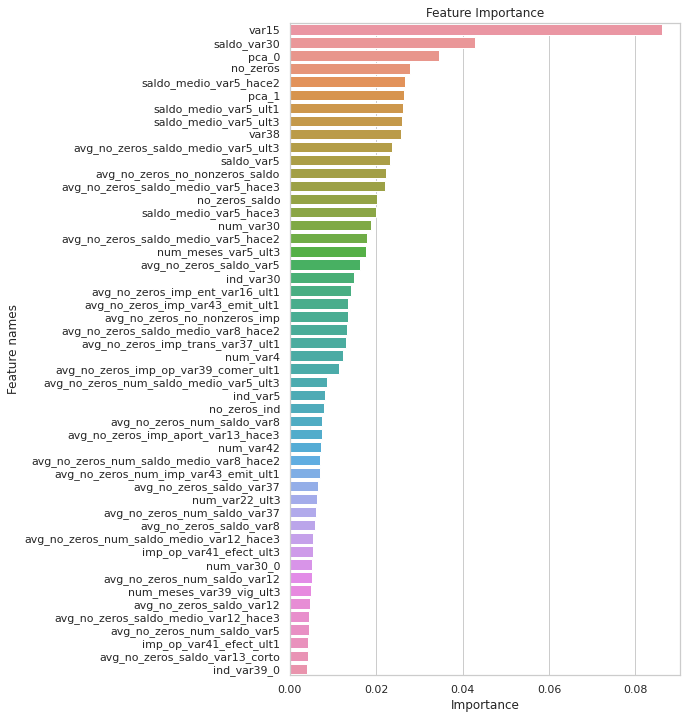

In [ ]:
plot_feature_importance(X_train,model.feature_importances_,top=50,size=(7,12))

We will create new datasets with less features.

In [18]:
#getting top k features
top=250
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_200 = X_train[features].copy()
X_val_200 = X_val[features].copy()
X_test_200 = X_test[features].copy()

Taking top 250 features


# XGB Classifier

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=750,
                      reg_alpha = 0.2,
                      max_depth=6, 
                      gamma=0, random_state=42
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.805762	validation_0-error:0.039726
[1]	validation_0-auc:0.814789	validation_0-error:0.039551
[2]	validation_0-auc:0.824039	validation_0-error:0.039551
[3]	validation_0-auc:0.823033	validation_0-error:0.039551
[4]	validation_0-auc:0.823704	validation_0-error:0.039551
[5]	validation_0-auc:0.824998	validation_0-error:0.039551
[6]	validation_0-auc:0.826246	validation_0-error:0.039551
[7]	validation_0-auc:0.827871	validation_0-error:0.039551
[8]	validation_0-auc:0.827678	validation_0-error:0.039551
[9]	validation_0-auc:0.827459	validation_0-error:0.039551
[10]	validation_0-auc:0.826225	validation_0-error:0.039551
[11]	validation_0-auc:0.825665	validation_0-error:0.039551
[12]	validation_0-auc:0.82375	validation_0-error:0.039551
[13]	validation_0-auc:0.824506	validation_0-error:0.039551
[14]	validation_0-auc:0.824725	validation_0-error:0.039551
[15]	validation_0-auc:0.82555	validation_0-error:0.039551
[16]	validation_0-auc:0.826104	validation_0-error:0.039551
[17]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=750, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer on Log Transformed dataset 		 



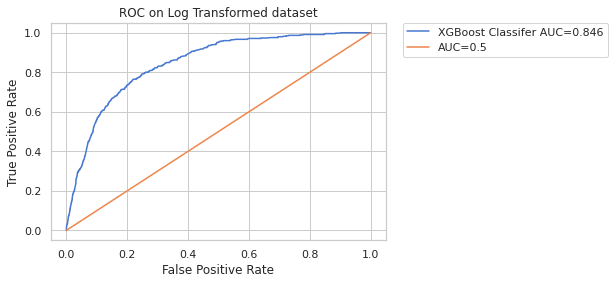

The log loss and auc was found to be 0.133 and 0.846 for XGBoost Classifer on Log Transformed dataset.


In [ ]:
y_pred = model.predict_proba(X_val)[:,1]
label="XGBoost Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.542156,0.812097
1,Decision Tree Classifier,Log Transformed,0.140804,0.810465
2,Random Forest Classifier,Log Transformed,0.137558,0.832106
3,XGBoost Classifer,Log Transformed,0.133120,0.846170


# LightGBM Classifier

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = .5,
                      subsample = 0.7,
                      objective='binary', 
                      n_estimators=500,
                      reg_alpha = 0.3,
                      max_depth=8, 
                      gamma=0, random_state=42
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.819973	valid_0's binary_logloss: 0.165719
[2]	valid_0's auc: 0.821431	valid_0's binary_logloss: 0.165076
[3]	valid_0's auc: 0.82962	valid_0's binary_logloss: 0.164341
[4]	valid_0's auc: 0.830261	valid_0's binary_logloss: 0.163747
[5]	valid_0's auc: 0.829651	valid_0's binary_logloss: 0.16314
[6]	valid_0's auc: 0.83059	valid_0's binary_logloss: 0.162556
[7]	valid_0's auc: 0.831028	valid_0's binary_logloss: 0.162029
[8]	valid_0's auc: 0.832365	valid_0's binary_logloss: 0.161447
[9]	valid_0's auc: 0.832561	valid_0's binary_logloss: 0.160951
[10]	valid_0's auc: 0.833345	valid_0's binary_logloss: 0.160383
[11]	valid_0's auc: 0.833285	valid_0's binary_logloss: 0.159919
[12]	valid_0's auc: 0.832625	valid_0's binary_logloss: 0.159469
[13]	valid_0's auc: 0.831923	valid_0's binary_logloss: 0.159044
[14]	valid_0's auc: 0.83105	valid_0's binary_logloss: 0.158627
[15]	valid_0's auc: 0.830849	valid_0's binary_logloss: 0.15822
[16]	valid_0's auc: 0.830143	valid_0's binary_logloss:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=0, importance_type='split', learning_rate=0.01,
               max_depth=8, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=42,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer on Log Transformed dataset 		 



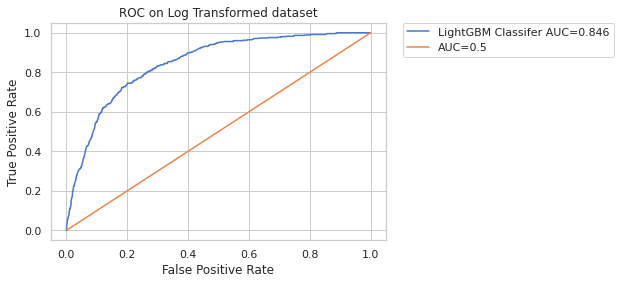

The log loss and auc was found to be 0.133 and 0.846 for LightGBM Classifer on Log Transformed dataset.


In [ ]:
y_pred = model.predict_proba(X_val)[:,1]
label="LightGBM Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.542156,0.812097
1,Decision Tree Classifier,Log Transformed,0.140804,0.810465
2,Random Forest Classifier,Log Transformed,0.137558,0.832106
3,XGBoost Classifer,Log Transformed,0.133120,0.846170
4,LightGBM Classifer,Log Transformed,0.133139,0.845953


# Random Forest (top 250)

In [19]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [20]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_200)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 48.1min finished


The best auc score was 0.819
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 5min 24s, sys: 595 ms, total: 5min 24s
Wall time: 53min 30s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)
model.fit(X_train_200,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_200,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (top 250) on Log Transformed dataset 		 



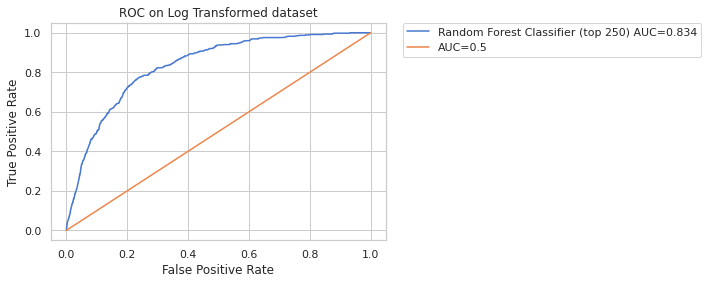

The log loss and auc was found to be 0.137 and 0.834 for Random Forest Classifier (top 250) on Log Transformed dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val_200)[:,1]
label="Random Forest Classifier (top 250)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.542156,0.812097
1,Decision Tree Classifier,Log Transformed,0.140804,0.810465
2,Random Forest Classifier,Log Transformed,0.137558,0.832106
3,XGBoost Classifer,Log Transformed,0.133120,0.846170
4,LightGBM Classifer,Log Transformed,0.133139,0.845953
5,Random Forest Classifier (top 250),Log Transformed,0.137108,0.833931


# XGB Classifier (top 250)

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 0.3,
                      max_depth=7,
                      gamma=0, random_state=42
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.787881	validation_0-error:0.040691
[1]	validation_0-auc:0.790846	validation_0-error:0.039551
[2]	validation_0-auc:0.798136	validation_0-error:0.039814
[3]	validation_0-auc:0.80953	validation_0-error:0.039639
[4]	validation_0-auc:0.815435	validation_0-error:0.039551
[5]	validation_0-auc:0.82069	validation_0-error:0.039639
[6]	validation_0-auc:0.822988	validation_0-error:0.039551
[7]	validation_0-auc:0.825401	validation_0-error:0.039551
[8]	validation_0-auc:0.826905	validation_0-error:0.039551
[9]	validation_0-auc:0.827275	validation_0-error:0.039551
[10]	validation_0-auc:0.827274	validation_0-error:0.039551
[11]	validation_0-auc:0.825432	validation_0-error:0.039551
[12]	validation_0-auc:0.826985	validation_0-error:0.039551
[13]	validation_0-auc:0.825223	validation_0-error:0.039551
[14]	validation_0-auc:0.825304	validation_0-error:0.039551
[15]	validation_0-auc:0.827608	validation_0-error:0.039551
[16]	validation_0-auc:0.825988	validation_0-error:0.039551
[17]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

		 XGBoost Classifer(top 250) on Log Transformed dataset 		 



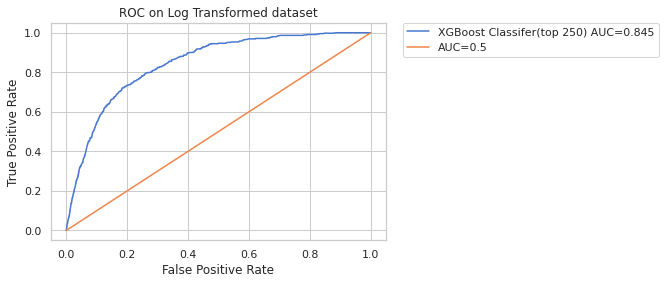

The log loss and auc was found to be 0.133 and 0.845 for XGBoost Classifer(top 250) on Log Transformed dataset.


In [ ]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="XGBoost Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.542156,0.812097
1,Decision Tree Classifier,Log Transformed,0.140804,0.810465
2,Random Forest Classifier,Log Transformed,0.137558,0.832106
3,XGBoost Classifer,Log Transformed,0.133120,0.846170
4,LightGBM Classifer,Log Transformed,0.133139,0.845953
5,Random Forest Classifier (top 250),Log Transformed,0.137108,0.833931
6,XGBoost Classifer(top 250),Log Transformed,0.133440,0.844712


# LightGBM Classifier (top 250)

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary', 
                      n_estimators=447,
                      reg_alpha = 0,
                      max_depth=6, random_state=42
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.79329	valid_0's binary_logloss: 0.165848
[2]	valid_0's auc: 0.820076	valid_0's binary_logloss: 0.16517
[3]	valid_0's auc: 0.814173	valid_0's binary_logloss: 0.164671
[4]	valid_0's auc: 0.820841	valid_0's binary_logloss: 0.164035
[5]	valid_0's auc: 0.820201	valid_0's binary_logloss: 0.163464
[6]	valid_0's auc: 0.825365	valid_0's binary_logloss: 0.162866
[7]	valid_0's auc: 0.827802	valid_0's binary_logloss: 0.162305
[8]	valid_0's auc: 0.827564	valid_0's binary_logloss: 0.161797
[9]	valid_0's auc: 0.825965	valid_0's binary_logloss: 0.161297
[10]	valid_0's auc: 0.826814	valid_0's binary_logloss: 0.160783
[11]	valid_0's auc: 0.828067	valid_0's binary_logloss: 0.160246
[12]	valid_0's auc: 0.830816	valid_0's binary_logloss: 0.159704
[13]	valid_0's auc: 0.829419	valid_0's binary_logloss: 0.159275
[14]	valid_0's auc: 0.829174	valid_0's binary_logloss: 0.158819
[15]	valid_0's auc: 0.827977	valid_0's binary_logloss: 0.1584
[16]	valid_0's auc: 0.829211	valid_0's binary_logloss

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=447, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=42, reg_alpha=0, reg_lambda=0.0,
               scale_pos_weight=1, silent=True, subsample=0.9,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 250) on Log Transformed dataset 		 



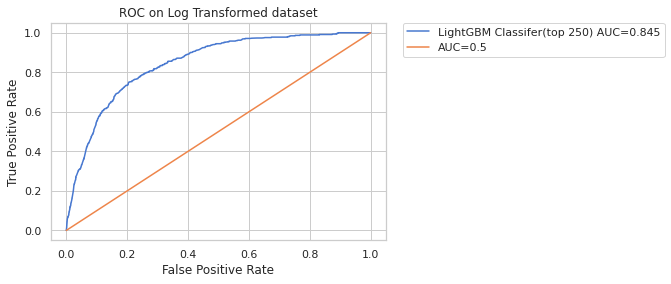

The log loss and auc was found to be 0.133 and 0.845 for LightGBM Classifer(top 250) on Log Transformed dataset.


In [ ]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="LightGBM Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

# Combined

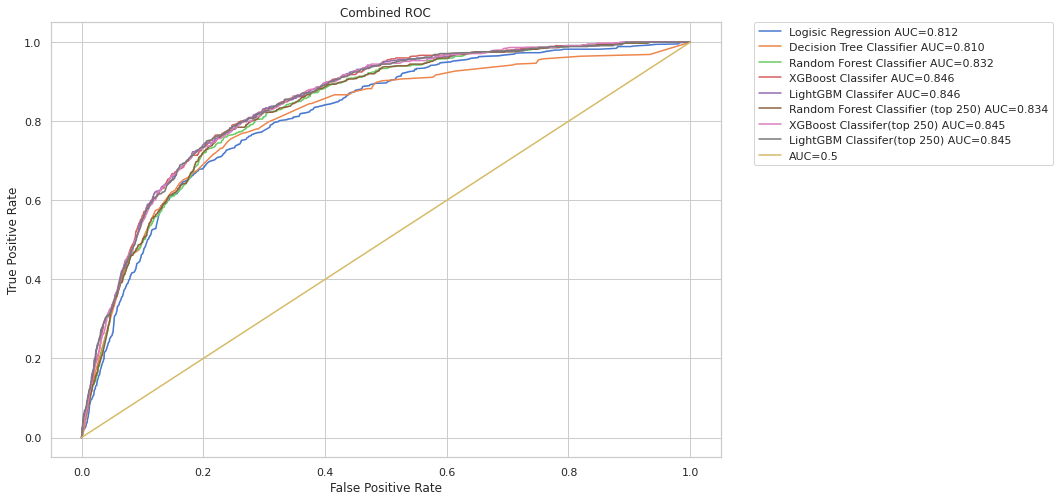

In [ ]:
plot_auc(y_val,y_preds,labels)

In [ ]:
result_df.sort_values(by='auc',ascending=False)

,Model,Dataset,log_loss,auc
3,XGBoost Classifer,Log Transformed,0.133120,0.846170
4,LightGBM Classifer,Log Transformed,0.133139,0.845953
7,LightGBM Classifer(top 250),Log Transformed,0.133359,0.845345
6,XGBoost Classifer(top 250),Log Transformed,0.133440,0.844712
5,Random Forest Classifier (top 250),Log Transformed,0.137108,0.833931
2,Random Forest Classifier,Log Transformed,0.137558,0.832106
0,Logisic Regression,Log Transformed,0.542156,0.812097
1,Decision Tree Classifier,Log Transformed,0.140804,0.810465


# Saving all the datasets created

In [ ]:

filename = 'log_train.pkl'
X_train.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_val.pkl'
X_val.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_test.pkl'
X_test.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_train_250.pkl'
X_train_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_val_250.pkl'
X_val_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_test_250.pkl'
X_test_200.to_pickle(os.path.join(file_path,'best_models',filename))
